###### Notebook to show how to flexibly select and plot subsets of the data from the store

In [2]:
import os
import json
import sys
import pandas as pd
import matplotlib.patches
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

In [3]:
# path to the store
store_path = os.path.join(sys.path[0], 'example_data/store.h5')
# the store object
store = pd.HDFStore(store_path, 'r')

### Example 1: Select all of the experiments and plot the trajectories

In [4]:
# the columns we need in order to plot the trajectories
trajectory_columns = ['x_raw', 'y_raw', 'arena', 'timedelta', 'start_string']
all_trajectories_df = store.select('data', columns = trajectory_columns)
all_trajectories_df.index = all_trajectories_df['timedelta']

In [5]:
# print the start_string(unique identifier) of all of the experiments we selected
start_strings = all_trajectories_df['start_string'].unique()

print start_strings
print '{} experiments'.format(len(start_strings))

['2016-02-04-13-03-04' '2016-02-04-13-02-15' '2016-02-04-13-00-10'
 '2016-02-04-12-59-12' '2016-02-04-12-56-43' '2016-02-04-12-57-28'
 '2016-02-04-13-04-27' '2016-02-04-13-06-25' '2016-02-16-17-14-42'
 '2016-02-16-17-27-24']
10 experiments


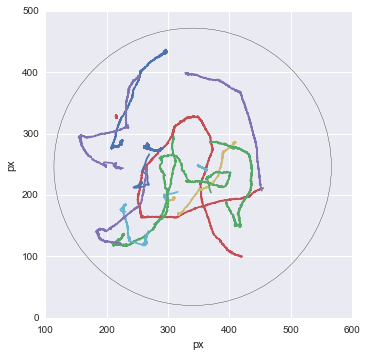

In [6]:
# get the arena dictionary
arena = json.loads(all_trajectories_df.ix[0, 'arena'])

fig, ax = plt.subplots(1)

# plot the arena
circle = matplotlib.patches.Circle((arena['cx_raw'], arena['cy_raw']), arena['r_raw'], fill=False)
ax.add_patch(circle)

# plot the trajectories experiment by experiment
for exp_name, exp_df in all_trajectories_df.groupby('start_string'):
    ax.plot(exp_df['x_raw'], exp_df['y_raw'])

ax.set_xlabel('px')
ax.set_ylabel('px')
ax.set_aspect('equal')

### Example 2: Select only 'stimulation experiments' and plot the mean forward velocity over genotypes

In [7]:
# the columns we need in order to plot the forward velocity over genotypes and binary genotypes
vel_columns = ['v', 'timedelta', 'start_string', 'laser_change', 'genotype', 'binary_genotype']
# select above 'vel_columns' of experiments with study 3+1+3x2 (stimulation experiments)
stimulation_vel_df = store.select('data', "columns = {} & (study == '3+1+3x2')".format(vel_columns))
stimulation_vel_df.index = stimulation_vel_df['timedelta']

In [9]:
# print the start_string(unique identifier) of all of the experiments we selected
start_strings = stimulation_vel_df['start_string'].unique()

print start_strings
print '{} experiments'.format(len(start_strings))

['2016-02-04-13-03-04' '2016-02-04-13-02-15' '2016-02-04-13-00-10'
 '2016-02-04-12-59-12' '2016-02-04-12-56-43' '2016-02-04-12-57-28'
 '2016-02-04-13-04-27' '2016-02-04-13-06-25']
8 experiments


Notice that now we only selected 8 experiments as opposed to the 10 above

In [52]:
# print the genotypes of all of the experiments we selected
print stimulation_vel_df['genotype'].unique()

['cs' 'gr28bdtntin' 'gr28bdtnte' 'trpa1000']


In [92]:
def plot_timeseries(df, y_column, bin_column_name):
    timegrouper = pd.TimeGrouper('100L', kind='timedelta', sort=True)
    fig, ax = plt.subplots(1)

    # seperate the dataframe into genotype-dataframes
    for genotype, genotype_df in df.groupby(bin_column_name):
        # make timegroups
        time_groups = genotype_df.groupby(timegrouper, sort=True)
        # get the timedeltas of those timegroups
        x = [x.total_seconds() for x in time_groups[y_column].mean().index]
        # get the mean y_column in those timegroups
        y = time_groups[y_column].mean().values
        ax.plot(x, y, label=genotype)
        
    laser_ons = genotype_df[genotype_df['laser_change'] == 1].index.total_seconds()
    laser_offs = genotype_df[genotype_df['laser_change'] == -1].index.total_seconds()
    # plot the laser on and offsets
    for laser_on, laser_off in zip(laser_ons, laser_offs):
        ax.axvspan(int(laser_on), int(laser_off), 180, 0, color='y')
    
    ax.legend()

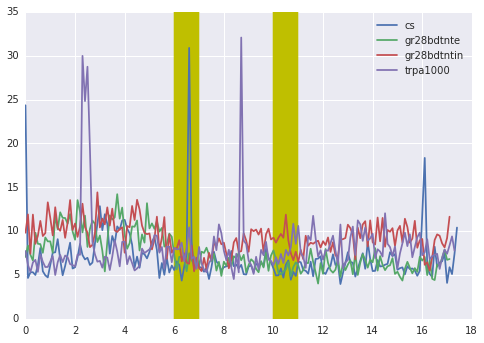

In [81]:
plot_timeseries(stimulation_vel_df, 'v', 'genotype')

### Example 3: Using the above selection plot the mean forward velocity of control vs. experimental animals

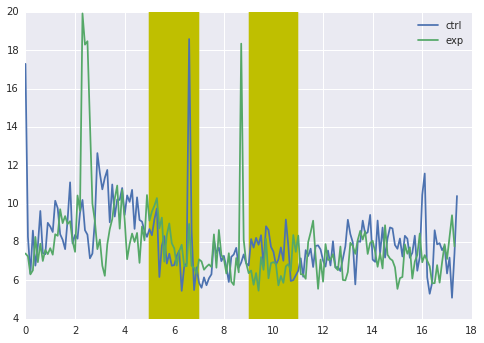

In [82]:
plot_timeseries(stimulation_vel_df, 'v', 'binary_genotype')

### Example 4: Only select the first section. Plot the mean angular velocity in the first section at different laser wavelengths

In [104]:
# the columns we need in order to plot the angular velocity in the first section over different laser wavelegths
ang_vel_columns = ['angular_velocity', 'timedelta', 'start_string', 'laser_change', 'flymad_setting', 'section']
# select above 'ang_vel_columns' of  the first section of experiments with study 3+1+3x2 (stimulation experiments)
stimulation_ang_vel_df = store.select('data', "columns = {} & (study == '3+1+3x2' & section == '0')".format(ang_vel_columns))
stimulation_ang_vel_df.index = stimulation_vel_df['timedelta']
# angular velocity in degrees
stimulation_ang_vel_df['angular_velocity'] = np.degrees(stimulation_ang_vel_df['angular_velocity'])
# the wavelength is the first five characters of the flymad_setting column
stimulation_ang_vel_df['wavelength'] = stimulation_ang_vel_df['flymad_setting'].str[:5]

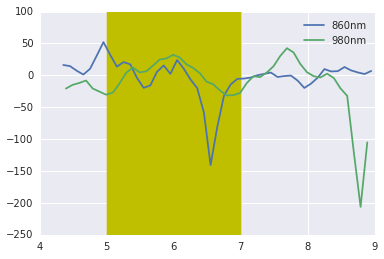

In [105]:
plot_timeseries(stimulation_ang_vel_df, 'angular_velocity', 'wavelength')